# Next frame prediction

The project consists of predicting the next frame in a short movie sequence.

For this project, we shall use the Moving MNIST dataset, composed of 10,000 video sequences, each consisting of 20 frames. In each video sequence, two digits move independently around the frame, which has a spatial resolution of 64×64 pixels. The digits frequently intersect with each other and bounce off the edges of the frame.

While each sequence has a lenght of 20, your are supposed to use **only 3 consecutive frames as input**, and **predict the next one**.

The metric used to evalaute the quality of the predicted frame is Mean Squared Error.

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from keras import layers

import math
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
ds = tfds.as_numpy(tfds.load(
    'moving_mnist',
    split='test',
    batch_size=-1
))
sequences = ds['image_sequence']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/moving_mnist/1.0.0.incompleteCDXXHN/moving_mnist-test.tfrecord*...:   0%| …

Dataset moving_mnist downloaded and prepared to /root/tensorflow_datasets/moving_mnist/1.0.0. Subsequent calls will reuse this data.


In [ ]:
sequences.shape

(10000, 20, 64, 64, 1)

The dataset is composed of 10000 sequences of 20 frames each. Each (grayscale) frame has dimnesion 64x64

In [ ]:
sequences = sequences/255.
print(sequences.shape)
print(np.min(sequences),np.max(sequences))

(10000, 20, 64, 64, 1)
0.0 1.0


Let us split the dataset in training, validation and testing.
You are supposed to evaluate the performance of your model using MSE over the full test set.

In [ ]:
trainset = sequences[:8000]
valset = sequences[8000:9000]
testset = sequences[8000:9000]

Here is a simple generator, creating the input sequences of 3 frames, and the expected output, namely the next frame.

In [ ]:
#I modified the generator given in order to adjust it for the format
#required by ConvLSTM2D layer
def image_generator(dataset,batchsize=16,seqlen=4):
    while True:
      batch_x = np.zeros((batchsize,seqlen-1,64,64,1))
      batch_y = np.zeros((batchsize,1,64,64,1))
      ran = np.random.randint(dataset.shape[0],size=batchsize)
      minibatch = dataset[ran]
      #these sequences have length 20; we reduce them to seqlen
      for i in range(batchsize):
          random_start = np.random.randint(0,20-seqlen)
          random_end = random_start+seqlen-1
          batch_x[i] = minibatch[i,random_start:random_end,:,:,:]
          batch_y[i] = minibatch[i,random_end:random_end+1,:,:,:]
          #print(batch_x.shape,batch_y.shape)
          #print(batch_x.min(),batch_x.max())
          #print(batch_x.min(),batch_x.max())
          yield(batch_x,batch_y)

In [ ]:
prova_gen = image_generator(testset,batchsize=1,seqlen=4)

In [ ]:
sample_x, sample_y = next(prova_gen)

In [ ]:
sample_x.shape

(1, 3, 64, 64, 1)

In [ ]:
def show_list(images): #takes in input a list of images and plot them
    size = len(images)
    plt.figure(figsize=(10, 10 * size))
    for i in range(size):
        plt.subplot(1, size, i + 1)
        plt.imshow(images[i],cmap='gray',)
    plt.axis("off")
    plt.tight_layout()
    plt.show()
    plt.close()

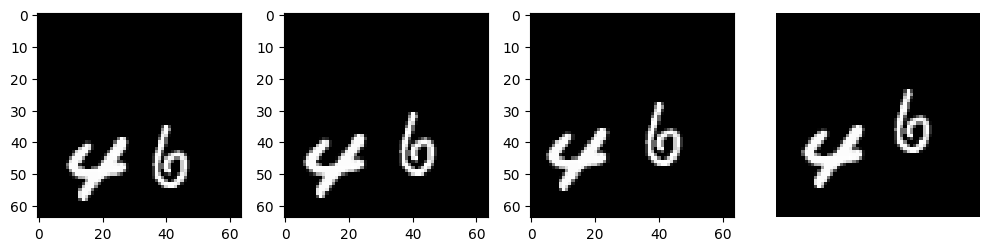

In [ ]:
all = [sample_x[0,i,:,:,0] for i in range(3)]+[sample_y[0,0,:,:,0]]
show_list(all)

In [ ]:
train_gen = image_generator(trainset)
val_gen = image_generator(valset)
test_gen = image_generator(testset)

In [ ]:
sample_x, sample_y = next(train_gen)

# What to deliver

As usual you are supposed to deliver a single notebook, sufficiently documented.
Do not erase the output cell of your notebook after the last execution. Especially, leave a sufficently verbose trace of training.

As already stated, the model must be evalauted on the full test set.

# Good work!

# Model 1

In [ ]:
from tensorflow.keras.layers import ConvLSTM2D, Conv3D, Concatenate, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint



In [ ]:
# Construct the input layer with size (batch_size=None, num_frames=3,width=64,height=64,channels=1).
inp = layers.Input(shape=(3, *trainset.shape[2:]))

#Encoding Network
x1 = ConvLSTM2D(128, (5,5), padding='same', return_sequences=True, kernel_initializer ='he_normal')(inp)
x2 = ConvLSTM2D(64, (5,5), padding='same', return_sequences=True, kernel_initializer ='he_normal')(x1)
x3 = ConvLSTM2D(64, (5,5), padding='same', return_sequences=True, kernel_initializer ='he_normal')(x2)

#Forecasting Network
x4 = ConvLSTM2D(128, (5,5), padding='same', return_sequences=True, kernel_initializer ='he_normal')(x1)
x5 = ConvLSTM2D(64, (5,5), padding='same', return_sequences=True, kernel_initializer ='he_normal')(x2)
x6 = ConvLSTM2D(64, (5,5), padding='same', return_sequences=True, kernel_initializer ='he_normal')(x3)

#Prediction Network
conc = Concatenate()([x4, x5, x6]) #
predictions = Conv3D(1, (5,5,5), activation='sigmoid', padding='same')(conc) #sigmoid original

# Next, we will build the complete model and compile it.

model2 = Model(inputs=inp, outputs=predictions)

In [ ]:
model2.compile(
    loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(0.001), metrics=[tf.keras.metrics.MeanSquaredError()]
)

In [ ]:
model2.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 3, 64, 64,   0           []                               
                                1)]                                                               
                                                                                                  
 conv_lstm2d_6 (ConvLSTM2D)     (None, 3, 64, 64, 1  1651712     ['input_3[0][0]']                
                                28)                                                               
                                                                                                  
 conv_lstm2d_7 (ConvLSTM2D)     (None, 3, 64, 64, 6  1229056     ['conv_lstm2d_6[0][0]']          
                                4)                                                          

## Model 1 training

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define some callbacks to improve training.

#EarlyStopping helps to stop training to avoid overfitting
early_stopping = keras.callbacks.EarlyStopping(monitor="val_mean_squared_error", patience=10)
#ReduceLROnPlateau reduces learning rate in case val_mean_squared_error is not improving
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_mean_squared_error', factor=0.5,
                              patience=3, min_lr=0.0001)

checkpoint_filepath = '/content/drive/MyDrive/DeepLearning/model2_weights1.h5'

#Save best model weights
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    save_best_only=True,
    verbose=1)


# Define modifiable training hyperparameters.
epochs = 50
steps_per_epoch = 100
#steps_per_epoch = trainset.shape[0] // 16
validation_steps = valset.shape[0] // 16

# Fit the model to the training data.
model2.fit(
    train_gen,
    steps_per_epoch= steps_per_epoch,
    epochs=epochs,
    validation_data= val_gen,
    validation_steps= validation_steps,
    callbacks=[early_stopping, reduce_lr, model_checkpoint],
    verbose=1
)




Epoch 1/50
100/100 [==============================] - ETA: 0s - loss: 0.0419 - mean_squared_error: 0.0098
Epoch 1: val_loss improved from inf to 0.04171, saving model to /content/drive/MyDrive/DeepLearning/model2_weights1.h5
100/100 [==============================] - 201s 2s/step - loss: 0.0419 - mean_squared_error: 0.0098 - val_loss: 0.0417 - val_mean_squared_error: 0.0098 - lr: 0.0010
Epoch 2/50
100/100 [==============================] - ETA: 0s - loss: 0.0387 - mean_squared_error: 0.0091
Epoch 2: val_loss did not improve from 0.04171
100/100 [==============================] - 199s 2s/step - loss: 0.0387 - mean_squared_error: 0.0091 - val_loss: 0.0425 - val_mean_squared_error: 0.0102 - lr: 0.0010
Epoch 3/50
100/100 [==============================] - ETA: 0s - loss: 0.0387 - mean_squared_error: 0.0090
Epoch 3: val_loss did not improve from 0.04171
100/100 [==============================] - 199s 2s/step - loss: 0.0387 - mean_squared_error: 0.0090 - val_loss: 0.0435 - val_mean_squared_e

## Evaluation of the Model 1

In [ ]:
#Load weights to the model
model2.load_weights('/content/drive/MyDrive/DeepLearning/model2_weights1.h5')

In [ ]:
#Model is evaluated using the test image generator
evaluation2 = model2.evaluate(
    test_gen,
    verbose=1,
    steps= testset.shape[0] // 16
)


62/62 [==============================] - 12s 198ms/step - loss: 0.0336 - mean_squared_error: 0.0075


In [ ]:
mse2 = evaluation2[model2.metrics_names.index('mean_squared_error')]
print('Mse of the model is ' + str(mse))

Mse of the model is 0.007763986475765705


##Frame Prediction Visualizations


In [ ]:
for _ in range(16):
  test_x, test_y = next(test_gen)

In [ ]:
y_predicted2 = model2.predict(test_x)

1/1 [==============================] - 1s 1s/step


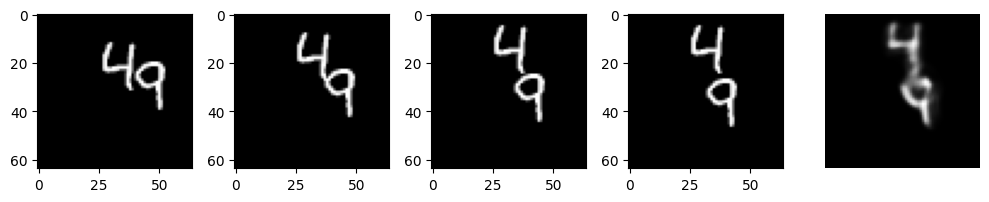

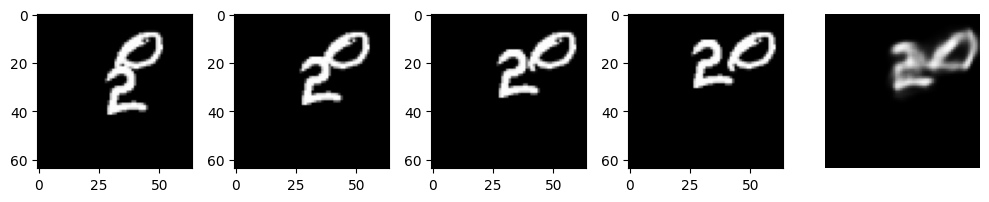

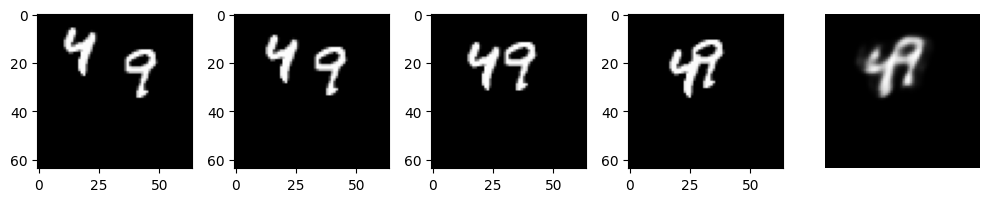

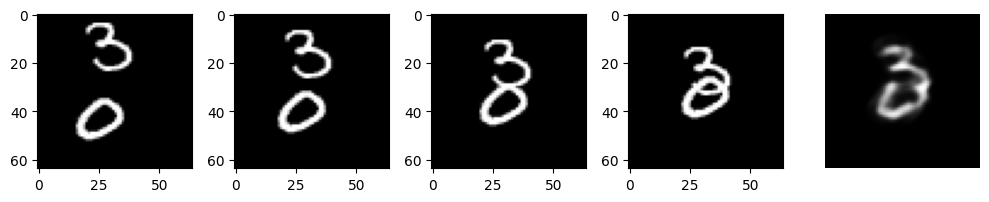

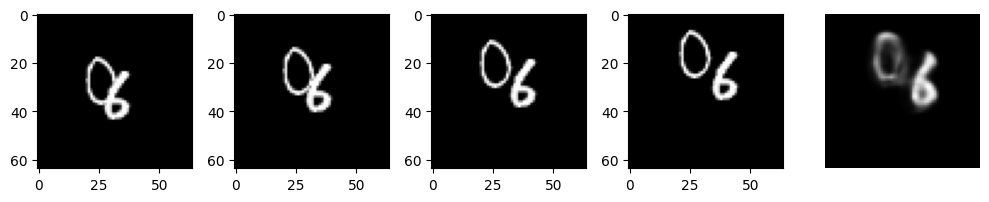

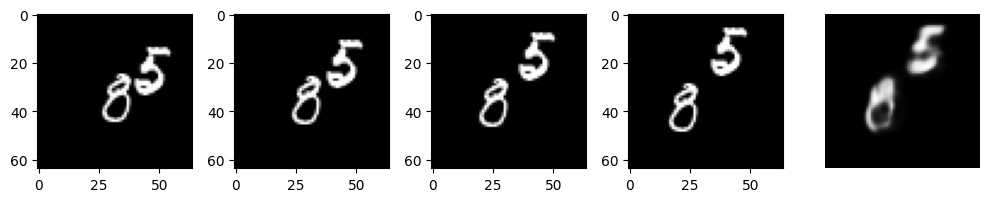

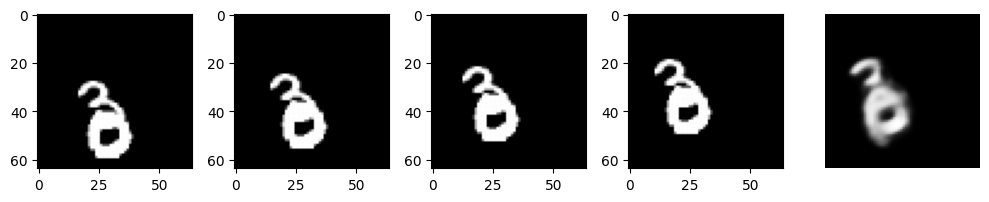

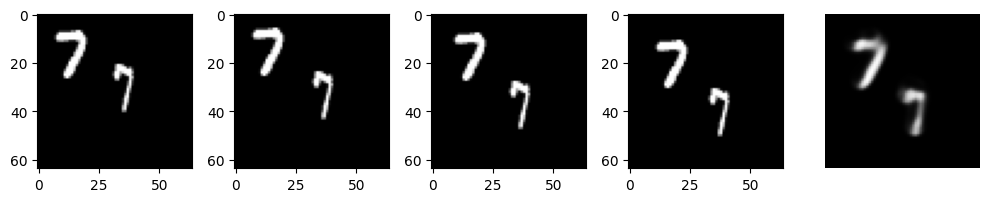

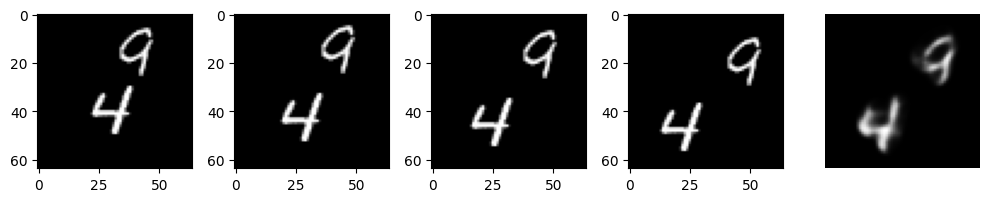

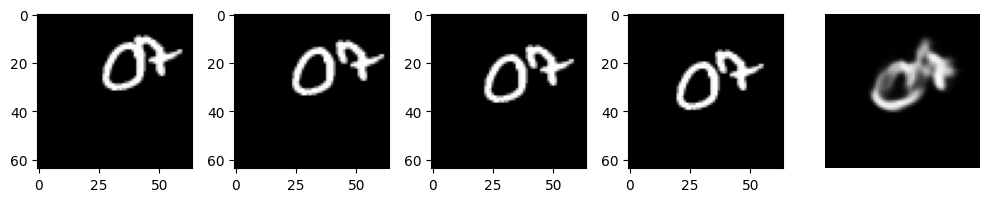

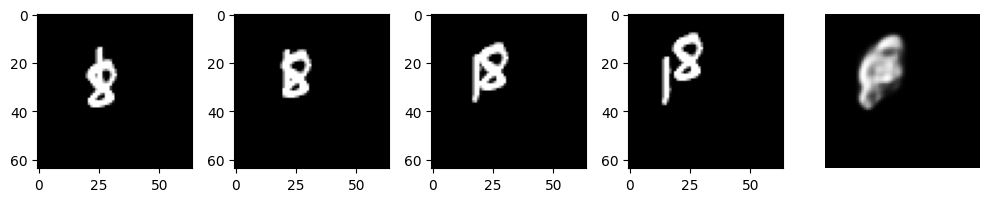

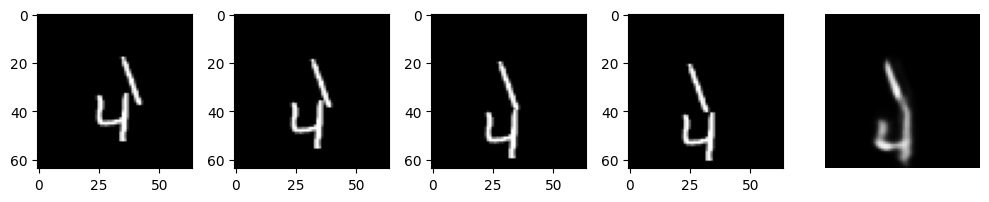

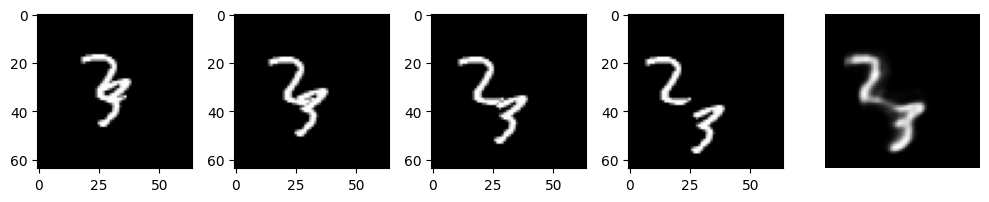

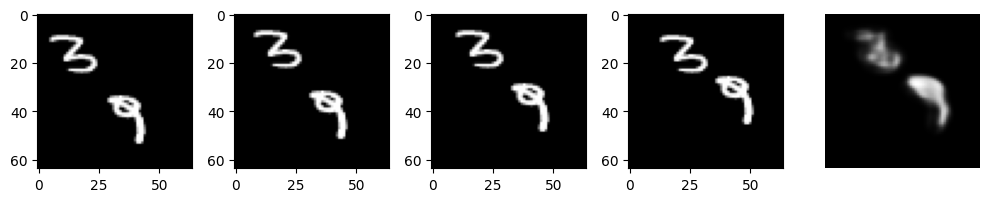

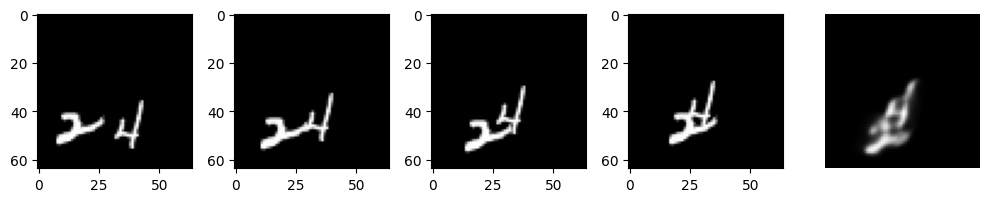

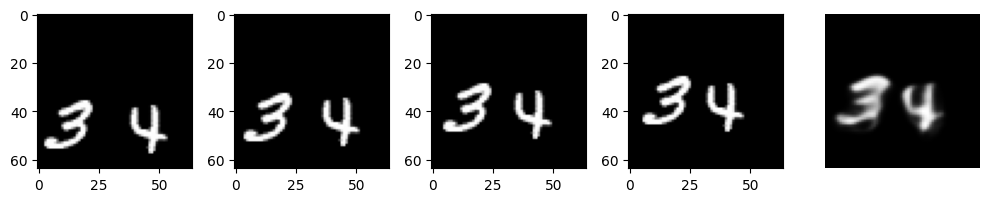

In [ ]:
#Three input frames, True Frame, Predicted Frame
for k in range(16):
  all = [test_x[k,i,:,:,0] for i in range(3)]+[test_y[k,0,:,:,0]]+[y_predicted2[k,-1,:,:,0]]
  show_list(all)

# Model 2


I also tried a more simple model, using just **746.689** parameters, compared to **8.648.449** parameter of the previus model (a reduction of more than 10 times in parameters).

In [ ]:
# Construct the input layer with size (batch_size=None, num_frames=3,width=64,height=64,channels=1).
inp = layers.Input(shape=(3, *trainset.shape[2:]))

# We will construct 3 ConvLSTM2D layers with batch normalization,
# followed by a Conv3D layer for output.
x = ConvLSTM2D(
    filters=64,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=True,
    activation="relu",
)(inp)
x = BatchNormalization()(x)
x = ConvLSTM2D(
    filters=64,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = BatchNormalization()(x)
x = ConvLSTM2D(
    filters=64,
    kernel_size=(1, 1),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
out = Conv3D(
    filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
)(x)


# Next, we will build the complete model and compile it.
model = Model(inp, out)

In [ ]:
model.compile(
    loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(0.001), metrics=[tf.keras.metrics.MeanSquaredError()]
)

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 3, 64, 64, 1)]    0         
                                                                 
 conv_lstm2d_3 (ConvLSTM2D)  (None, 3, 64, 64, 64)     416256    
                                                                 
 batch_normalization_2 (Batc  (None, 3, 64, 64, 64)    256       
 hNormalization)                                                 
                                                                 
 conv_lstm2d_4 (ConvLSTM2D)  (None, 3, 64, 64, 64)     295168    
                                                                 
 batch_normalization_3 (Batc  (None, 3, 64, 64, 64)    256       
 hNormalization)                                                 
                                                                 
 conv_lstm2d_5 (ConvLSTM2D)  (None, 3, 64, 64, 64)     3302

## Model 2 training

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define some callbacks to improve training.

#EarlyStopping helps to stop training to avoid overfitting
early_stopping = EarlyStopping(monitor="val_mean_squared_error", patience=10, min_delta=0.001)
#ReduceLROnPlateau reduces learning rate in case val_mean_squared_error is not improving
reduce_lr = ReduceLROnPlateau(monitor='val_mean_squared_error', factor=0.5,
                              patience=3, min_lr=0.0001)

checkpoint_filepath = '/content/drive/MyDrive/DeepLearning/model1_weights1.h5'

#Save best model weights
model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    save_best_only=True,
    verbose=1)


# Define modifiable training hyperparameters.
epochs = 50
steps_per_epoch = trainset.shape[0] // 16
validation_steps = valset.shape[0] // 16

# Fit the model to the training data.
model.fit(
    train_gen,
    steps_per_epoch= steps_per_epoch,
    epochs=epochs,
    validation_data= val_gen,
    validation_steps= validation_steps,
    callbacks=[early_stopping, reduce_lr, model_checkpoint],
    verbose=1
)

Epoch 1/50
500/500 [==============================] - ETA: 0s - loss: 0.0466 - mean_squared_error: 0.0103
Epoch 1: val_loss improved from inf to 0.04908, saving model to /content/drive/MyDrive/DeepLearning/model1_weights1.h5
500/500 [==============================] - 57s 113ms/step - loss: 0.0466 - mean_squared_error: 0.0103 - val_loss: 0.0491 - val_mean_squared_error: 0.0110 - lr: 2.5000e-04
Epoch 2/50
500/500 [==============================] - ETA: 0s - loss: 0.0468 - mean_squared_error: 0.0104
Epoch 2: val_loss improved from 0.04908 to 0.04871, saving model to /content/drive/MyDrive/DeepLearning/model1_weights1.h5
500/500 [==============================] - 56s 112ms/step - loss: 0.0468 - mean_squared_error: 0.0104 - val_loss: 0.0487 - val_mean_squared_error: 0.0110 - lr: 2.5000e-04
Epoch 3/50
500/500 [==============================] - ETA: 0s - loss: 0.0470 - mean_squared_error: 0.0105
Epoch 3: val_loss improved from 0.04871 to 0.04846, saving model to /content/drive/MyDrive/DeepLea

## Evaluation of Model 2

In [ ]:
#Load weights to the model
model.load_weights('/content/drive/MyDrive/DeepLearning/model1_weights1.h5')

In [ ]:
#Model is evaluated using the test image generator
evaluation = model.evaluate(
    test_gen,
    verbose=1,
    steps= testset.shape[0] // 16
)


62/62 [==============================] - 2s 37ms/step - loss: 0.0456 - mean_squared_error: 0.0100


In [ ]:
mse = evaluation[model.metrics_names.index('mean_squared_error')]
print('Mse of the model is ' + str(mse))

Mse of the model is 0.009972203522920609


## Frame Prediction Visualization

In [ ]:
y_predicted = model.predict(test_x)

1/1 [==============================] - 1s 582ms/step


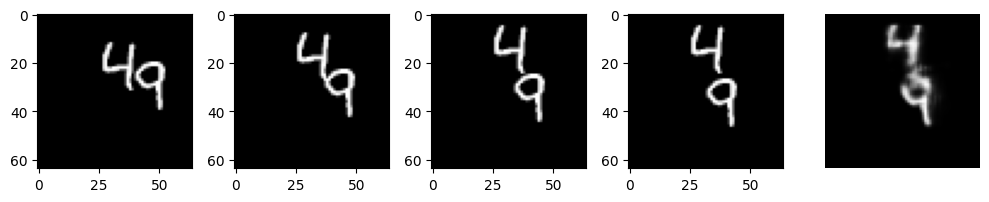

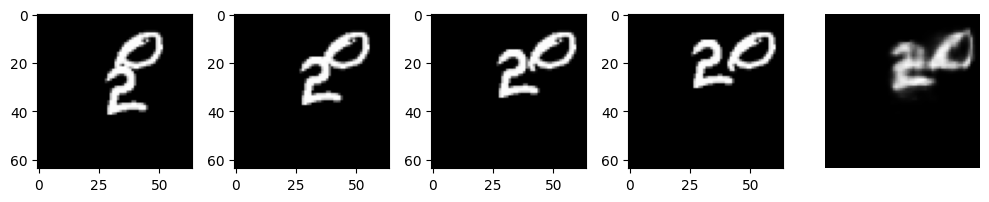

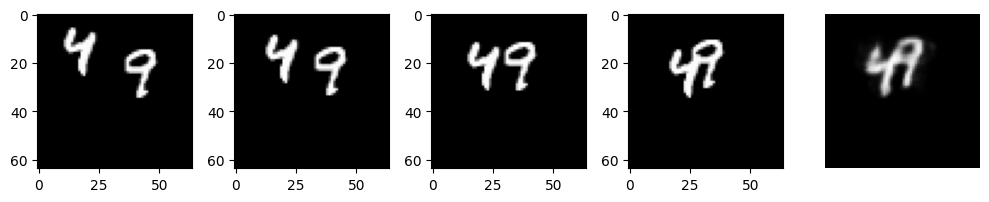

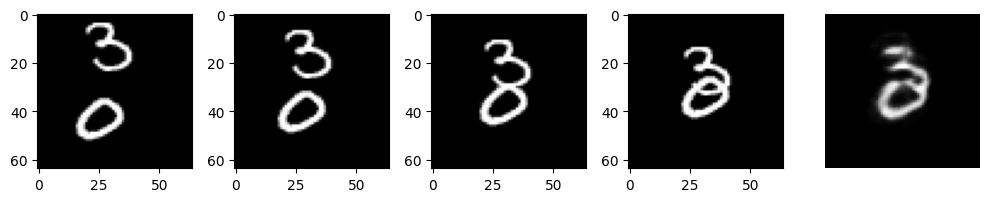

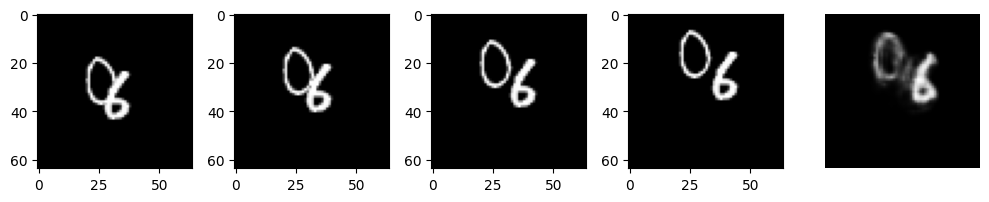

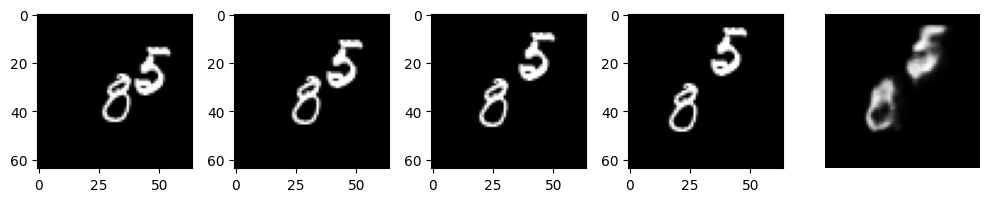

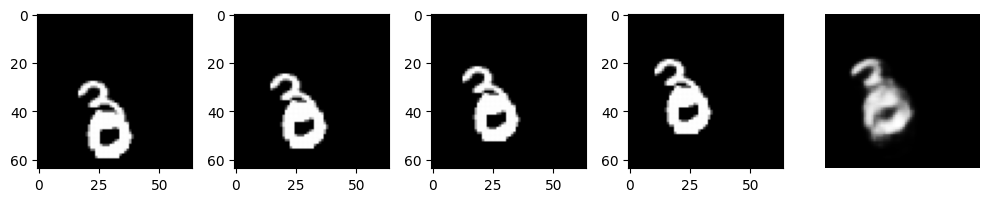

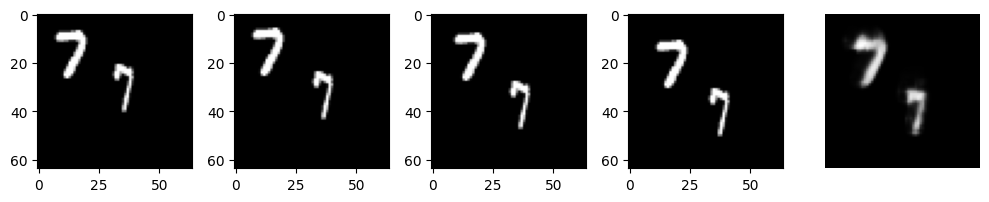

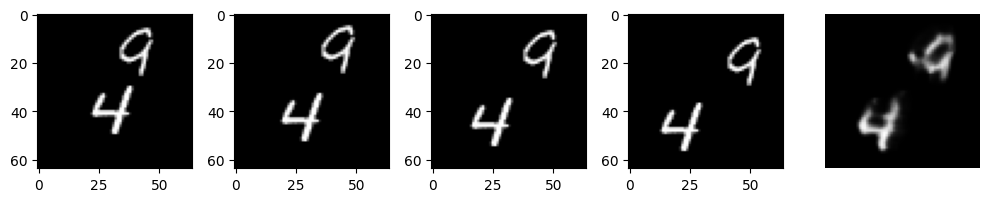

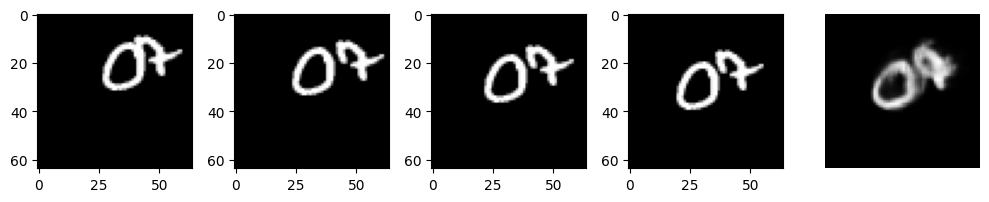

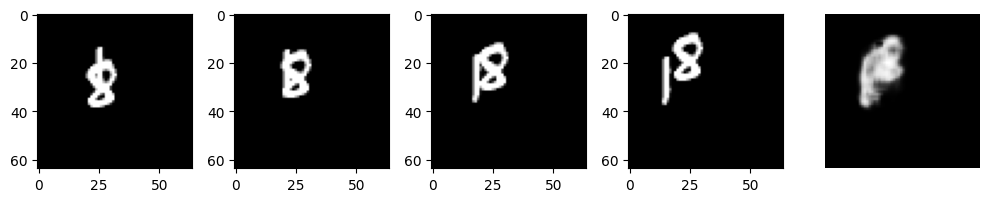

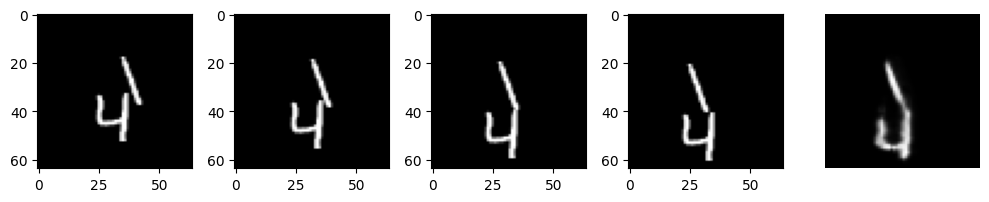

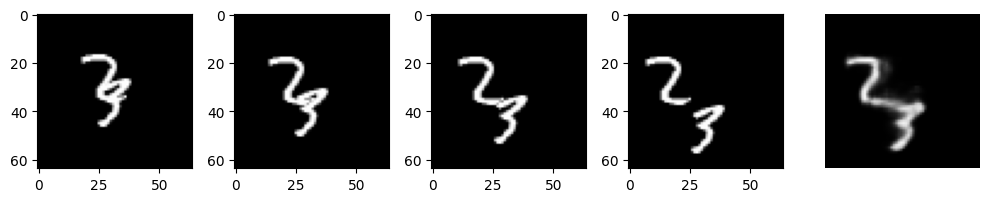

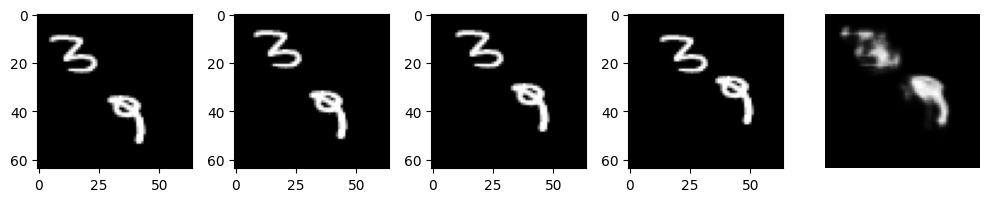

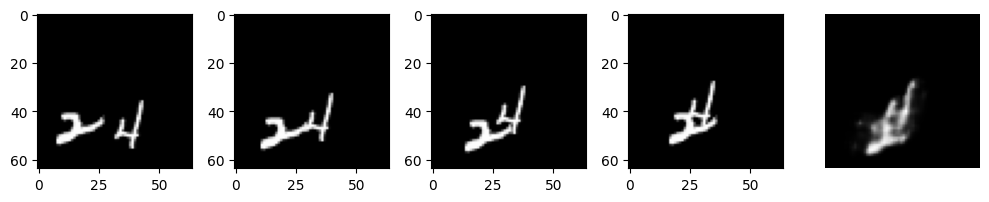

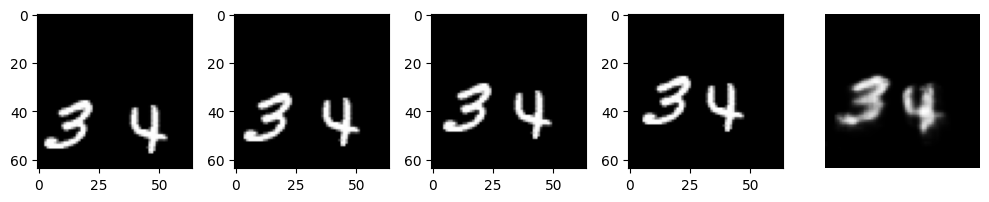

In [ ]:
#Three input frames, True Frame, Predicted Frame
for k in range(16):
  all = [test_x[k,i,:,:,0] for i in range(3)]+[test_y[k,0,:,:,0]]+[y_predicted[k,-1,:,:,0]]
  show_list(all)

# Conclusions

In [ ]:
diff = round(mse2 - mse,6)
improv = round((mse2 / mse - 1)*100,2)

In [ ]:
concl= f"Comparing Model 1 and Model 2, we see a difference in MSE of {diff} which is equivalent to a reduction of {improv}% in the error. \n However, if you compare the graphical outputs (Frame prediction visualization), you won't see much difference. \n For this reason, the simplest model would be better, having into account that is 10 times smaller the size"
print(concl)

Comparing Model 1 and Model 2, we see a difference in MSE of -0.002515 which is equivalent to a reduction of -25.22% in the error. 
 However, if you compare the graphical outputs (Frame prediction visualization), you won't see much difference. 
 For this reason, the simplest model would be better, having into account that is 10 times smaller the size


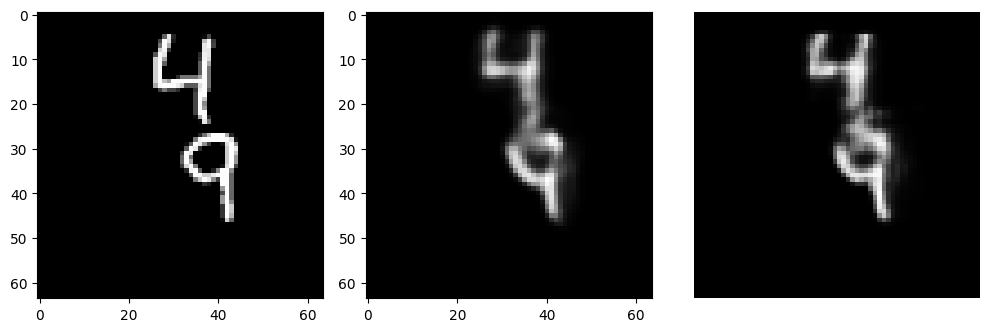

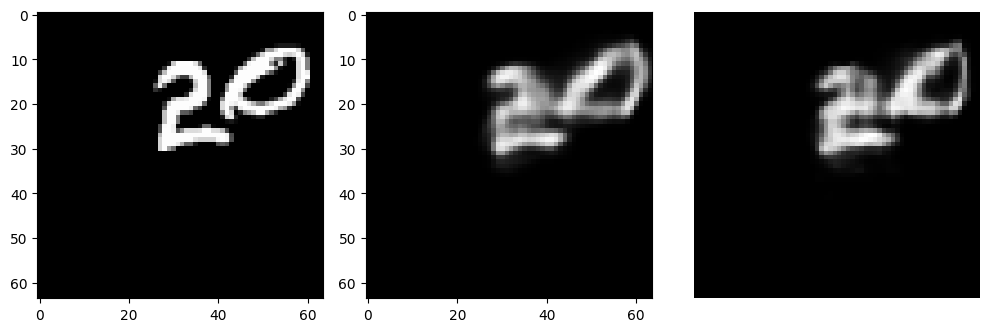

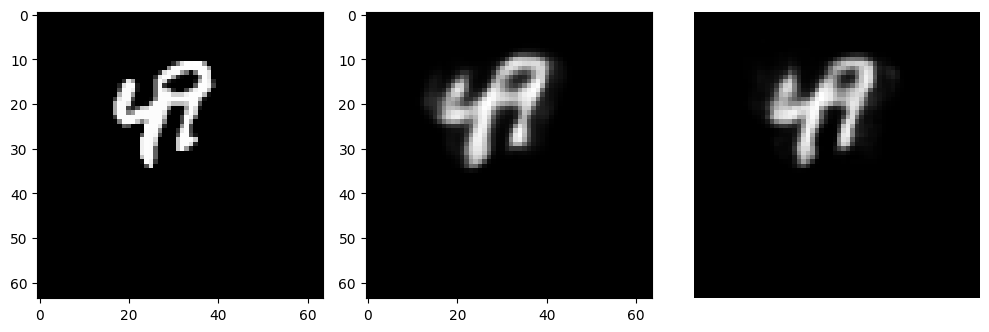

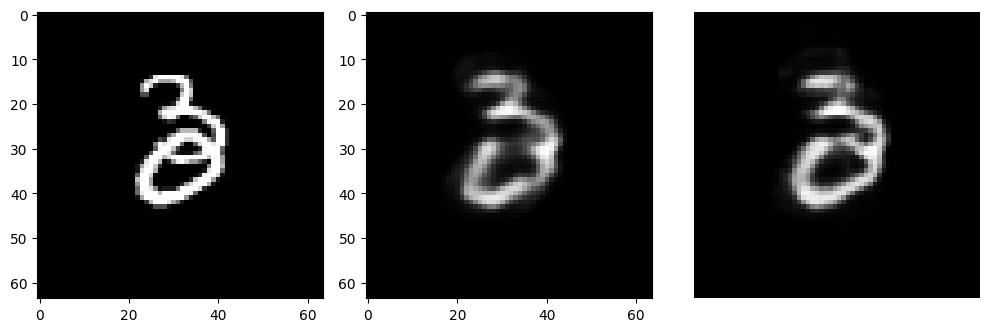

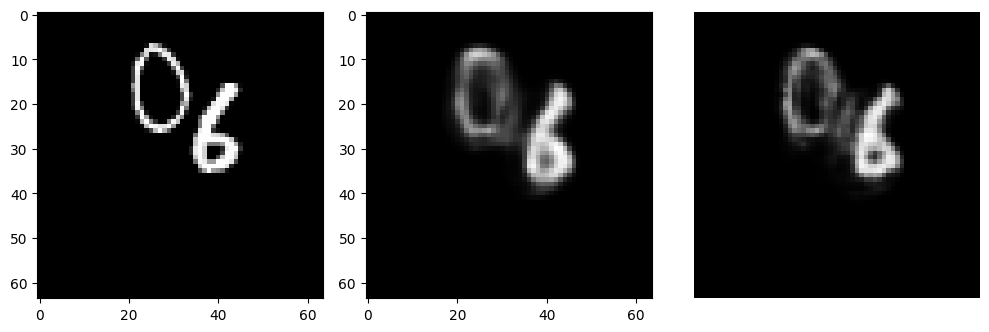

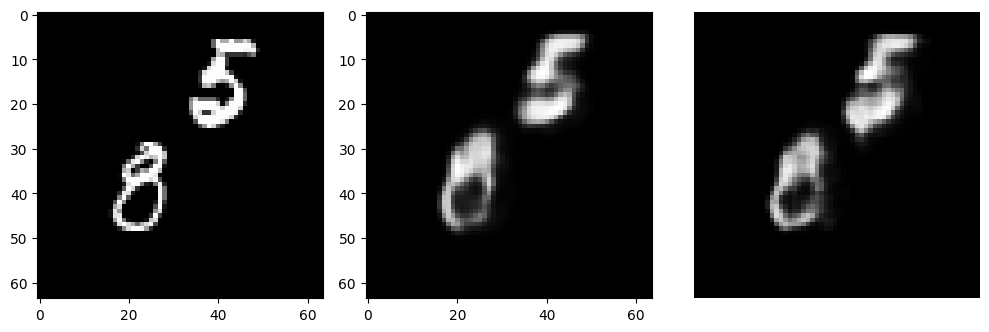

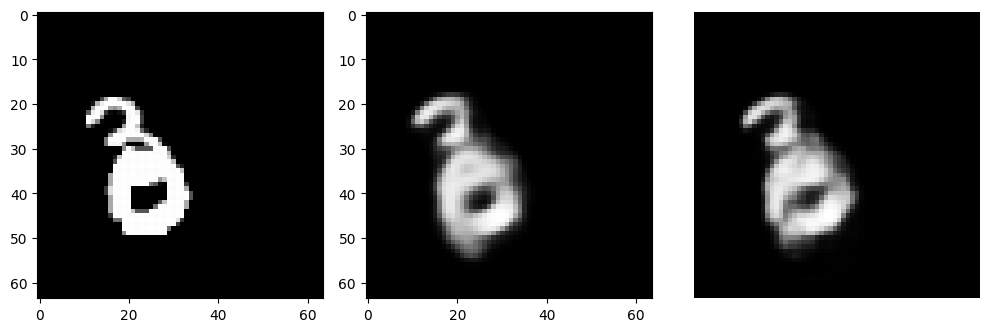

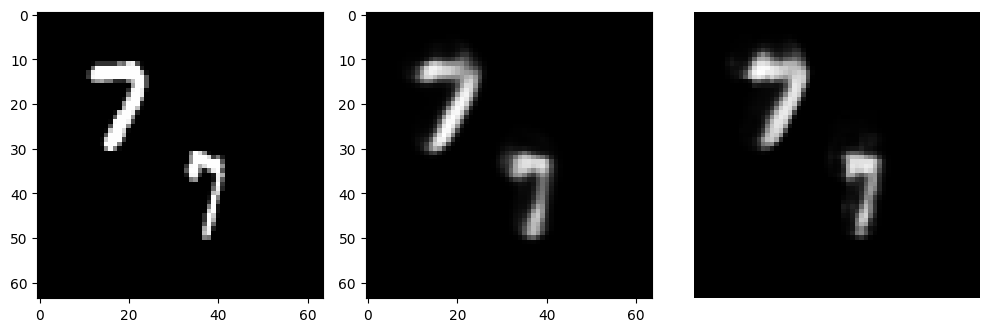

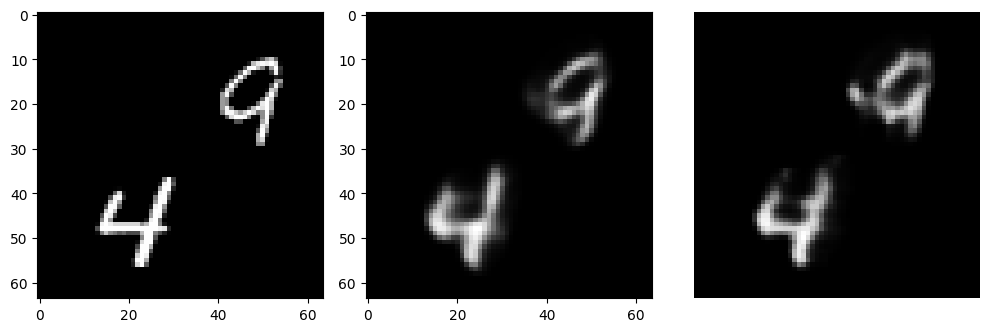

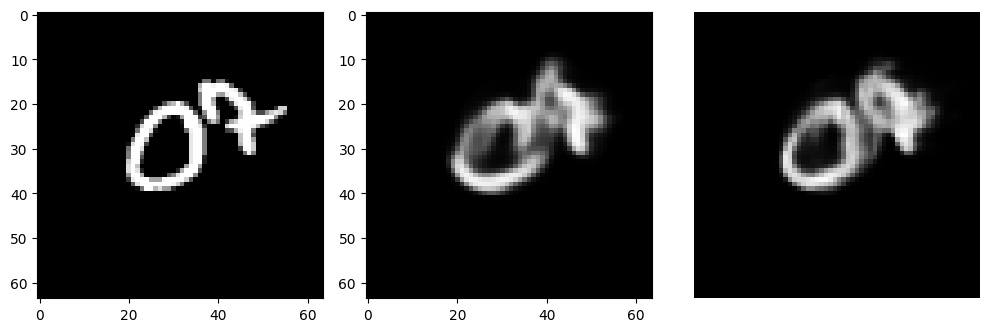

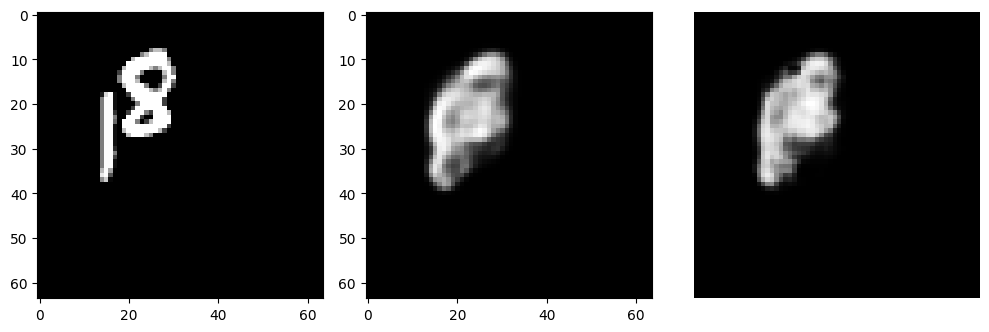

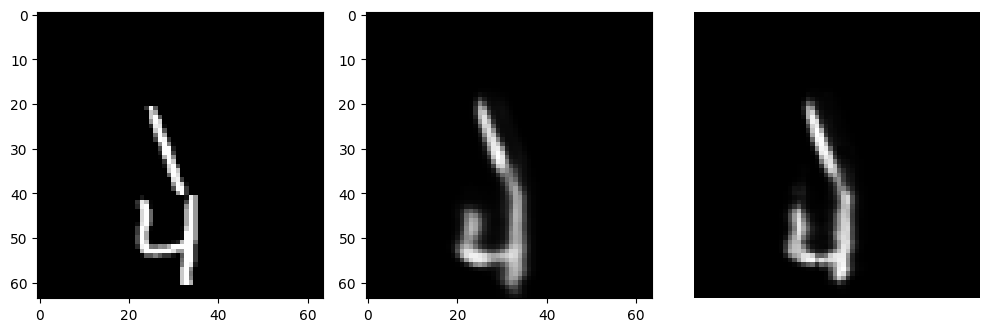

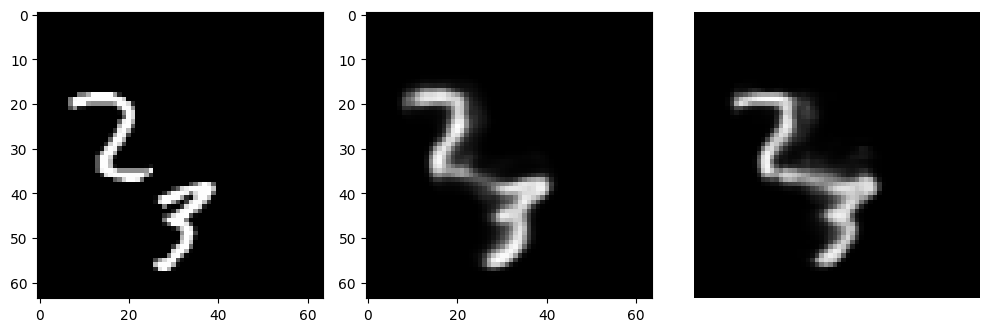

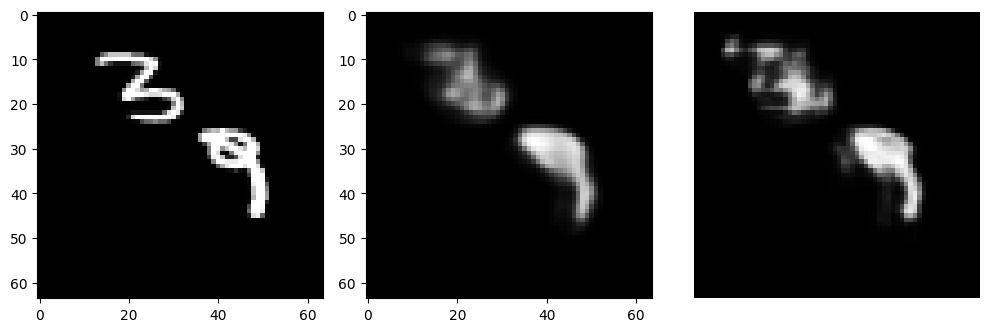

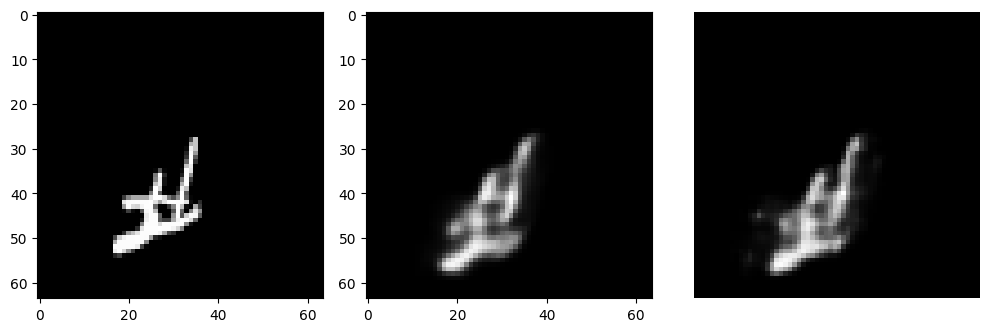

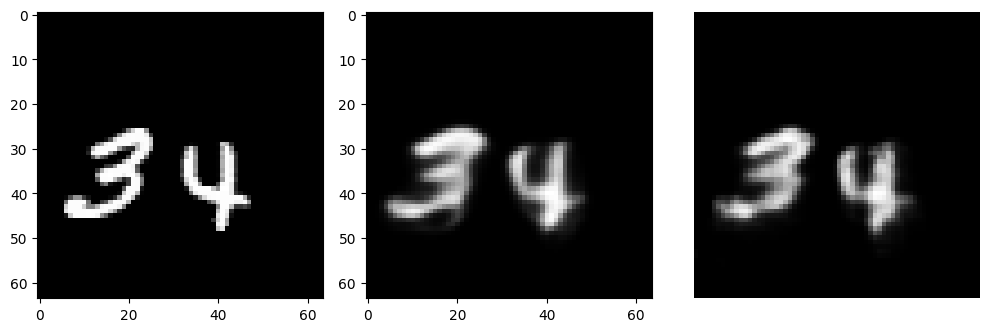

In [ ]:
#True frame, Predicted Frame Model 1, Predicted Frame Model 2
for k in range(16):
  all = [test_y[k,0,:,:,0]] + [y_predicted2[k,-1,:,:,0]] + [y_predicted[k,-1,:,:,0]]
  show_list(all)